In [1]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def process_image(srcname, dstname=None, demo=False):
    img0 = cv2.imread(srcname)

    gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.medianBlur(gray0, 9)
    _, gray2 = cv2.threshold(255 - gray1, 135, 255, cv2.THRESH_TRUNC)
    gray2 = 255 - gray2

    _, thresh0 = cv2.threshold(-gray2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel1 = np.ones((7, 7), dtype=np.uint8)
    kernel2 = np.ones((9, 9), dtype=np.uint8)
    thresh1 = cv2.morphologyEx(thresh0, cv2.MORPH_OPEN, kernel1, iterations=2)
    thresh2 = cv2.dilate(thresh1, kernel2, iterations=2)

    dt = cv2.distanceTransform(thresh1, cv2.DIST_L2, 5)
    sure_bg = np.max(thresh2) - thresh2
    _, sure_fg = cv2.threshold(dt, 0.1 * np.max(dt), 255, cv2.THRESH_BINARY)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(thresh2, sure_fg)

    _, markers0 = cv2.connectedComponents(sure_fg)
    markers0 = markers0 + 1
    markers0[unknown==255] = 0
    markers1 = markers0.copy()
    img1 = cv2.bitwise_not(img0, 0, 255-thresh0)
    markers1 = cv2.watershed(img1, markers1)
    result = cv2.medianBlur(img0, 3)
    result[markers1 == -1] = [0,255,0]

    icell, scell = -1, -1
    for i in range(2, np.max(markers1) + 1):
        s = np.count_nonzero(markers1[markers1 == i])
        if (s > scell):
            icell, scell = i, s

    row, col = np.where(markers1 == icell)
    left, right = np.min(col), np.max(col)
    top, bottom = np.min(row), np.max(row)

    fval = 0
    img2 = img0.copy()
    img2[markers1 != icell] = (fval, fval, fval)
    subimg = img2[top:bottom+1, left:right+1]
    width, height = right - left, bottom - top
    ver_margin, hor_margin = (160 - height) // 2, (160 - width) // 2
    img3 = np.full(img2.shape, fval, dtype=np.uint8)
    img3[ver_margin:ver_margin+height+1, hor_margin:hor_margin+width+1] = subimg

    img_yuv = cv2.cvtColor(img3, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    img_fin = cv2.medianBlur(img_out, 3)
    
    if dstname != None:
        cv2.imwrite(dstname, img_fin)
        #cv2.imwrite(dstname, cv2.cvtColor(img_fin, cv2.COLOR_BGR2GRAY))

    if not demo:        
        return img_fin
        
    # Visualization
    plt.figure(figsize=(18, 12.2))

    rows, cols = 2, 3
    ax = [plt.subplot(rows, cols, i+1) for i in range(rows * cols)]
    for a in ax:
        a.axis('off')
        a.set_xticklabels([])
        a.set_yticklabels([])
    plt.subplots_adjust(wspace=0.02, hspace=0.02)

    plt.subplot(rows, cols, 1), plt.imshow(gray0, 'gray')
    plt.subplot(rows, cols, 2), plt.imshow(thresh0, 'gray')
    plt.subplot(rows, cols, 3), plt.imshow(markers0, 'gray')
    plt.subplot(rows, cols, 4), plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.subplot(rows, cols, 5), plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.subplot(rows, cols, 6), plt.imshow(cv2.cvtColor(img_fin, cv2.COLOR_BGR2RGB))
    
    return img_fin

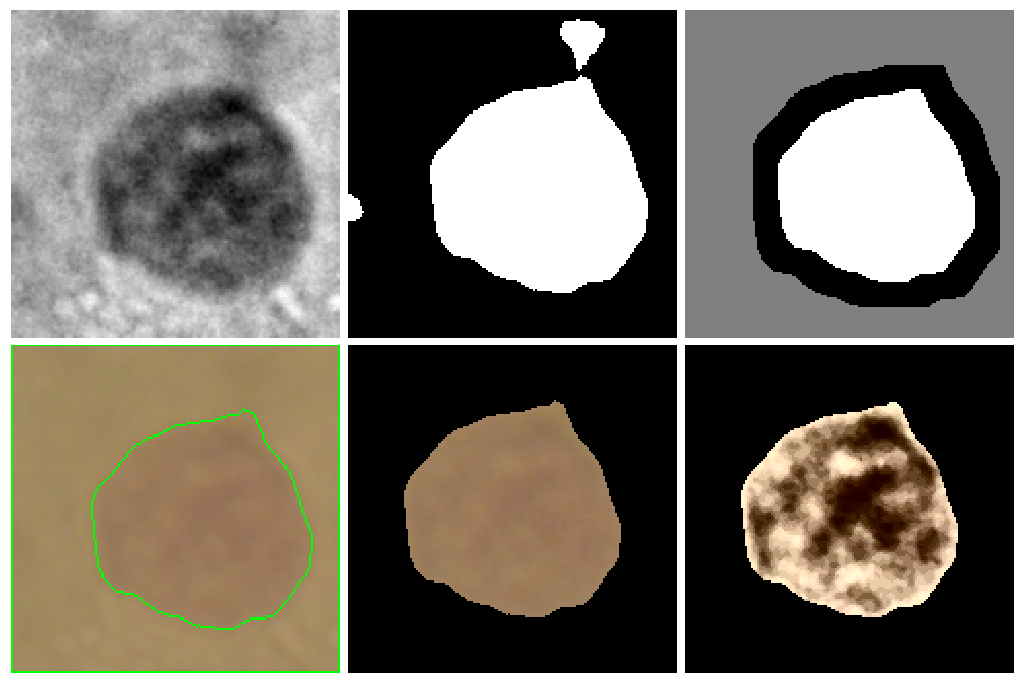

In [3]:
_ = process_image('../all_data/cancer/404_1_1.png', demo=True)

In [163]:
ldir = os.listdir('../all_data/cancer/')
srclist = [os.path.join('..', 'all_data', 'cancer', x) for x in ldir]
dstlist = [os.path.join('dataset', 'cancer', x) for x in ldir]

for i in tqdm(range(len(srclist)), ascii=True):
    process_image(srclist[i], dstlist[i], False)

100%|##########| 3403/3403 [00:48<00:00, 70.73it/s] 


In [164]:
ldir = os.listdir('../all_data/fibroadenomas/')
srclist = [os.path.join('..', 'all_data', 'fibroadenomas', x) for x in ldir]
dstlist = [os.path.join('dataset', 'fibro', x) for x in ldir]

for i in tqdm(range(len(srclist)), ascii=True):
    process_image(srclist[i], dstlist[i], False)

100%|##########| 1741/1741 [00:20<00:00, 83.48it/s] 


In [5]:
ldir = os.listdir('../all_data/FAM_NEW/')
srclist = [os.path.join('..', 'all_data', 'FAM_NEW', x) for x in ldir]
dstlist = [os.path.join('dataset', 'FAM_NEW', x) for x in ldir]

for i in tqdm(range(len(srclist)), ascii=True):
    process_image(srclist[i], dstlist[i], False)

100%|##########| 442/442 [00:03<00:00, 111.79it/s]
